In [2]:
from sstadex import Macromodel, Test, cs_pmos, Primitive, dfs, diffpair_cc, current_mirror_cc, spice_sim, cm_pmos
from sympy import Symbol
from sympy import lambdify

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm

import paretoset as pareto

import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

sys.path.insert(0, "../../..")
from gmid.mosplot import load_lookup_table, LoadMosfet

In [3]:
## Exploration parameters

N_points = 10
lengths_nmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]
lengths_pmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

lut_file = "../../LUTs/gf_LUT_03v3.npy"
lut_w = 20e-6

## Electrical parameters

Vout = 1.2                                      # LDO output voltage
Vin = 1.8                                    # LDO supply voltage
Vref = 0.9                                      # LDO voltage reference
IL = 5e-3                                     # Load current
CL = 0.5e-12                                    # Load capacitance
RL = Vout/IL

## LDO specifications

efficiency = 0.98
psrr_condition = -70
estability_condition = 60
linereg_condition = 0.5
loadreg_condition = 0.7
#iq_condition = 20e-6
size_condition = 1e-3

I_bias = 5e-6
I_amp1 = 10e-6 # considering the two branches of differential pair
I_amp2 = 20e-6

Iq_max = IL*(1-efficiency)
Ib_pt = Iq_max-I_amp2-I_bias

R1 = (Vout-Vref)/Ib_pt
R2 = Vref*R1/(Vout-Vref)

LDO = pd.DataFrame.from_dict({'Vout': [Vout], 'Vin': [Vin], 'Vref': [Vref], 'IL': [IL], 'CL': [CL], 'RL': [RL], 'Iq_max': [Iq_max], 'Ib_pt': [Ib_pt], 'R1': [R1], 'R2': [R2]}, orient='index', columns=['Value'])
LDO

,Value
Vout,1.200000e+00
Vin,1.800000e+00
Vref,9.000000e-01
IL,5.000000e-03
CL,5.000000e-13
RL,2.400000e+02
Iq_max,1.000000e-04
Ib_pt,7.500000e-05
R1,4.000000e+03
R2,1.200000e+04


In [4]:
Vota = 0.688

In [5]:
## LDO MACROMODEL

LDO_macro = Macromodel(
    name ='LDO_macro', 
    outputs= [
        Symbol("W_diff_m1"), Symbol("L_diff_m1"),
        Symbol("W_diff_m2"), Symbol("L_diff_m2"),
        Symbol("W_aload_m1"), Symbol("L_aload_m1"),
        Symbol("W_aload_m2"), Symbol("L_aload_m2"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol("W_pt"), Symbol("L_pt"),
        Symbol("W_cc"), Symbol("L_cc"),
        Symbol("W_rc"), Symbol("L_rc")],
    electrical_parameters={
        "Vdd": Vin, 
        "Vref": Vref, 
        "Vout": Vout, 
        "Vota": Vota,
        "Il": IL+Ib_pt}
    )

## OTA CASCODE DIFFPAIR MACROMODEL

OTA_macro = Macromodel(
    name = 'OTA_macro',
    outputs = [
        Symbol("W_diff_m1"), Symbol("L_diff_m1"),
        Symbol("W_diff_m2"), Symbol("L_diff_m2"),
        Symbol("W_aload_m1"), Symbol("L_aload_m1"),
        Symbol("W_aload_m2"), Symbol("L_aload_m2"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs')
    ],
    electrical_parameters = {
        "Vdd": LDO_macro.electrical_parameters["Vdd"],
        "Vref": LDO_macro.electrical_parameters["Vref"],
        "Vout": LDO_macro.electrical_parameters["Vota"],
        "Il": I_amp2},
    macromodel_parameters={
        Symbol('Ra'): np.logspace(3, 7, N_points),
        Symbol('gma'): np.logspace(-5, -2, N_points)}
    )

In [6]:
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(100/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

##############################################################################

dc_LDO_macro = Test()
dc_LDO_macro.name = "dc_LDO"
dc_LDO_macro.tf = ["vout", "vdd"]
dc_LDO_macro.netlist = "ldo"
dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

dc_LDO_macro.opt_goal = "min"
dc_LDO_macro.conditions = {"min": [0]}
dc_LDO_macro.variables = {}
dc_LDO_macro.out_def = {"eval": dc_LDO_macro.tf}
x = Symbol("x")
dc_LDO_macro.lamd = lambdify(x, x*3.3)

##############################################################################

gain_ol_LDO_macro = Test()
gain_ol_LDO_macro.name = "gain_ol_LDO"
gain_ol_LDO_macro.tf = ["vout", "vol"]
gain_ol_LDO_macro.netlist = "ldo_ol"
gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

gain_ol_LDO_macro.opt_goal = "min"
gain_ol_LDO_macro.conditions = {"min": [1]}
gain_ol_LDO_macro.variables = {}
gain_ol_LDO_macro.out_def = {"eval": gain_ol_LDO_macro.tf}

##############################################################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [-300]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

In [7]:
gain_OTA = Test()
gain_OTA.tf = ("vout", "vpos")
gain_OTA.name = "gain_OTA"
gain_OTA.netlist = "ota_1stage"
gain_OTA.parametros = {
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("gdiff_2"): Symbol("gdiff_1"), 
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("V1"): 0,
    Symbol("V_b"): 0,
    Symbol("V_n"): 0,
    Symbol("V_p"): 1,
    Symbol("I2"): 0,
    Symbol("s"): 0,
    Symbol("Cl"): 1e-1}

gain_OTA.opt_goal = "max"
gain_OTA.conditions = {"min": [10**(-100/20)]}
gain_OTA.variables = {}
gain_OTA.out_def = {"eval": gain_OTA.tf}

#########################################################

phase_margin_OTA = Test()
phase_margin_OTA.name = "phase_margin_OTA"
phase_margin_OTA.tf = ["vout", "vpos"]
phase_margin_OTA.netlist = "OpAmp_2stage"
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): 1e-12}

phase_margin_OTA.opt_goal = "min"
phase_margin_OTA.conditions = {"min": [0]}
phase_margin_OTA.variables = {}
phase_margin_OTA.out_def = {"pm": phase_margin_OTA.tf}

##########################################################

rout_OTA = Test()
rout_OTA.name = "rout_OTA"
rout_OTA.target_param = Symbol("Ra")
rout_OTA.tf = ["vout", "vr"]
rout_OTA.netlist = "ota_1stage_rout"
rout_OTA.parametros = {Symbol("gdiff_2"): Symbol("gdiff_1"),
                              Symbol("Rdiff_2"): Symbol("Rdiff_1"),
                                Symbol("gaload_2"): Symbol("gaload_1"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_OTA.opt_goal = "max"
rout_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_OTA.variables = {}
rout_OTA.out_def = {"eval": rout_OTA.tf}

##########################################################

gm_OTA = Test()
gm_OTA.target_param = Symbol("gma")
gm_OTA.name = "gm_OTA"
gm_OTA.tf = ["vout", "vpos"]
gm_OTA.netlist = "ota_1stage"
gm_OTA.composed = 1
gm_OTA.out_def = {"divide": [gain_OTA, rout_OTA]}
gm_OTA.opt_goal = "max"
gm_OTA.conditions = {"min": [0.000000001]}

In [8]:
pt = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': LDO_macro.electrical_parameters["Vota"]-Vin, 
        'il': LDO_macro.electrical_parameters["Il"],
        'length': lengths_pmos, 
        '2d_var': ['length', 'vgs']})

pt_df = pt.build()

mask = (pt_df["width"]>5e-6) & (pt_df["width"]<15e-3)

pt_df = pt_df[mask]

pt.parameters = {
    Symbol('gm_pt'): pt_df['gm'].values,
    Symbol('Ro_pt'): pt_df['Ro'].values,
    Symbol("Cgg_pt"): pt_df['cgg'].values,
    Symbol("Cgd_pt"): pt_df['cgd'].values,
    Symbol("Cin_pt"): pt_df['cgg'].values+pt_df["cgd"].values*pt_df["gm"].values*pt_df["Ro"].values,
    Symbol("dropout"): 2/(pt_df["gm"].values/pt.inputs['il']),
    Symbol('Vota'): np.tile(LDO_macro.electrical_parameters["Vota"], 5)[mask]}

pt.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

# CASE 2: WITHOUT LOAD

## found operation point of the circuit with no load
lookup_table = load_lookup_table(lut_file)

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"],
            vgs=(-1.8, -0.1, 0.01),
            lengths=lengths_pmos,
        )

jd_2 = Ib_pt/pt.W.flatten()

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=pt.L.flatten(),
            z_expression=pt_lutable.vgs_expression,
        )

vgs_2 = np.diag(vgs_2)
print("Values of Vgs_pt when there is no load: ", vgs_2)
##

vout_2stage_wc = vgs_2

pt_wc = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': vout_2stage_wc, 
        'il': Ib_pt,
        'length': pt.L.flatten(), 
        '2d_var': ['length', 'vgs']})

pt_wc_df = pt_wc.build()

pt_wc.parameters = {
    Symbol('gm_pt'): pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol('Ro_pt'): pt_wc_df["Ro"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("Cgg_pt"): pt_wc_df["cgg"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("Cgd_pt"): pt_wc_df["cgd"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol("dropout"): 2/(pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]/pt_wc.inputs['il']),
    Symbol("Cin_pt"): pt_wc_df["cgg"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]
                        +pt_wc_df["cgd"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]
                        *pt_wc_df["gm"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask]*pt_wc_df["Ro"].values.reshape(len(vgs_2),-1).diagonal().flatten()[mask],
    Symbol('Vota'): Vin+vout_2stage_wc[mask]}

pt_wc.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

length
vgs
0
Values of Vgs_pt when there is no load:  [-0.74235348 -0.75078729 -0.74468328 -0.74106026 -0.73915898]
length
vgs
0


In [9]:
pt_df

,length,width,gdsid,gds,Ro,cgg,gm,cgs,cgd
0,4.000000e-07,0.000904,0.111553,0.000566,1766.375286,1.196766e-12,0.026593,-9.659837e-13,-2.251347e-15
1,8.000000e-07,0.002201,0.047427,0.000241,4154.684234,5.750674e-12,0.028136,-4.791936e-12,-1.778895e-14
2,1.600000e-06,0.004677,0.025238,0.000128,7807.465659,2.417268e-11,0.027751,-2.030255e-11,-5.975679e-14
3,3.200000e-06,0.009695,0.014447,0.000073,13638.691004,9.880726e-11,0.027473,-8.305795e-11,-1.726551e-13


In [10]:
sweep_size_dp = 5
vin_dp = OTA_macro.electrical_parameters["Vref"]
vout_dp = OTA_macro.electrical_parameters["Vout"]
vs_dp = np.linspace(0.1, vin_dp-0.1, sweep_size_dp)
vcp_dp = np.linspace(vin_dp, vout_dp-0.1, sweep_size_dp)

diffpair_primitive = diffpair_cc(
    vcp_dp, 
    vs_dp, 
    vin_dp, 
    vout_dp, 
    I_amp2/2, 
    sweep_size_dp, 
    lengths_nmos, 
    vout_dp + 0.5,
    lut_file,
    lut_w)

diffpair_primitive_df =  diffpair_primitive.build()

diffpair_primitive_mask = (diffpair_primitive_df["width_m1"]>1e-6) & (diffpair_primitive_df["width_m2"]>2e-6) & (diffpair_primitive_df["width_m1"]<4e-6) & (diffpair_primitive_df["width_m2"]<3e-4)

diffpair_primitive_df = diffpair_primitive_df[diffpair_primitive_mask]

diffpair_primitive.parameters = {Symbol("Rdiff_1"): diffpair_primitive_df["Ro"].values, 
                                 Symbol("gdiff_1"): diffpair_primitive_df["gm"].values,
                                 Symbol("vbias"): diffpair_primitive_df["vbias"].values,
                                 Symbol("vs_diff"): diffpair_primitive_df["vs"].values}

diffpair_primitive.outputs = {Symbol("W_diff_m1"): diffpair_primitive_df["width_m1"].values,
                              Symbol("W_diff_m2"): diffpair_primitive_df["width_m2"].values,
                              Symbol("L_diff_m1"): diffpair_primitive_df["length_m1"].values,
                              Symbol("L_diff_m2"): diffpair_primitive_df["length_m2"].values}

## OTA stage1 active load ################################################################

vout_cm = 0.688 - Vin
sweep_size_cm = 5

vcp_cm = np.linspace(vout_cm+0.1, -0.1, sweep_size_cm)

print("vout_cm: ", vout_cm)
print("vcp_cm: ", vcp_cm)

activeload_primmitive = current_mirror_cc(
    vcp_cm, 
    vout_cm, 
    I_amp2/2, 
    sweep_size_cm, 
    lengths_nmos, 
    vout_cm - 0.5,
    lut_file,
    lut_w)

activeload_primitive_df = activeload_primmitive.build()

activeload_primitive_mask = (activeload_primitive_df["width_m1"]>1e-6) & (activeload_primitive_df["width_m2"]>5e-6) & (activeload_primitive_df["width_m1"]<1e-4) & (activeload_primitive_df["width_m2"]<1e-4)
activeload_primitive_df = activeload_primitive_df[activeload_primitive_mask]

activeload_primmitive.parameters = {Symbol("Raload_1"): activeload_primitive_df["Ro"].values,
                                    Symbol("gaload_1"): activeload_primitive_df["gm"].values,
                                    Symbol("vbias_cm"): activeload_primitive_df["vbias"].values}
activeload_primmitive.outputs = {Symbol("W_aload_m1"): activeload_primitive_df["width_m1"].values,
                                 Symbol("L_aload_m1"): activeload_primitive_df["length_m1"].values,
                                 Symbol("W_aload_m2"): activeload_primitive_df["width_m2"].values,
                                 Symbol("L_aload_m2"): activeload_primitive_df["length_m2"].values}
                                 

#############################################################################

currentsource = cm_pmos()
currentsource.parameters = {
    Symbol('gcs'): [],
    Symbol('Rcs'): [],
    Symbol('vs_cs'): [],
    Symbol('vgs_cs'): []}
currentsource.outputs = {
    Symbol("W_cs"): [],
    Symbol("L_cs"): []}

for vds_cs in vs_dp:

    vgs_cs = np.linspace(vds_cs-0.2, vds_cs+0.6, 5)

    currentsource_aux = cm_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': vds_cs, 
            'vgs_lut': (0.1, 1.8, 0.01), 
            'vgs': vgs_cs, 
            'il': I_amp2,
            'length': lengths_nmos, 
            '2d_var': ['length', 'vgs']})
    currentsource_aux.build()

    currentsource.parameters[Symbol('gcs')].append(np.asarray(currentsource_aux.gm).flatten())
    currentsource.parameters[Symbol('Rcs')].append(np.asarray(currentsource_aux.Ro).flatten())
    currentsource.parameters[Symbol('vs_cs')].append(np.asarray(np.repeat(vds_cs, len(lengths_nmos)*len(vgs_cs))).flatten())
    currentsource.parameters[Symbol('vgs_cs')].append(np.asarray(np.tile(vgs_cs, len(lengths_nmos))).flatten())
    currentsource.outputs[Symbol('W_cs')].append(np.asarray(currentsource_aux.W).flatten())
    currentsource.outputs[Symbol('L_cs')].append(np.asarray(currentsource_aux.L).flatten())


currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]

mask = (currentsource.outputs[Symbol('W_cs')]<3e-4) & (currentsource.outputs[Symbol('W_cs')]>1e-6)

currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()[mask]
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()[mask]
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()[mask]
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()[mask]
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()[mask]
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()[mask]
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]

vds
vgs
1
M1 jd:  [[3.99425947e+00 2.31289643e-01 3.09608127e-03 2.45039513e-05
  1.76873920e-07 3.95277800e+00 2.26741833e-01 3.01750044e-03
  2.36957920e-05            nan 3.91025099e+00 2.21935142e-01
  2.93284323e-03 2.25825767e-05            nan 3.86553825e+00
  2.17193154e-01 2.84405137e-03            nan            nan
  3.81803010e+00 2.12226604e-01 2.72912923e-03            nan
             nan]
 [1.84616068e+00 9.41745849e-02 1.22275138e-03 1.00301722e-05
  8.01316842e-08 1.83979580e+00 9.35324894e-02 1.21215301e-03
  9.90442011e-06            nan 1.83328858e+00 9.27829232e-02
  1.19958250e-03 9.71900657e-06            nan 1.82622820e+00
  9.20887879e-02 1.18677037e-03            nan            nan
  1.81860579e+00 9.13506147e-02 1.16860448e-03            nan
             nan]
 [1.05155676e+00 6.32473932e-02 8.99558837e-04 7.59023396e-06
  6.30052265e-08 1.04938174e+00 6.29819311e-02 8.94562860e-04
  7.52779840e-06            nan 1.04719922e+00 6.26557756e-02
  8.88403132e-04

In [11]:
diffpair_primitive_df

,width_m1,length_m1,width_m2,length_m2,gds,Ro,gm,cout,ccp,vbias,vs
104,0.000003,4.000000e-07,0.000091,4.000000e-07,1.017484e-07,9.828165e+06,0.000112,-2.100853e-16,1.163042e-14,1.188,0.1
729,0.000003,4.000000e-07,0.000201,8.000000e-07,4.428096e-08,2.258307e+07,0.000112,-1.760579e-16,2.328157e-14,1.188,0.1
1354,0.000003,4.000000e-07,0.000285,1.600000e-06,2.387673e-08,4.188178e+07,0.000112,-5.983750e-16,5.176817e-14,1.188,0.1


In [12]:
vout_2stage_wc = 1.05

In [13]:
diffpair_primitive_wc = diffpair_cc(
    vcp_dp, 
    vs_dp, 
    vin_dp, 
    vout_2stage_wc, 
    I_amp2/2, 
    sweep_size_dp, 
    lengths_nmos, 
    vout_dp + 0.5,
    lut_file,
    lut_w)

diffpair_primitive_df_wc =  diffpair_primitive_wc.build()

diffpair_primitive_wc.parameters = {Symbol("Rdiff_1"): diffpair_primitive_df_wc["Ro"].values[diffpair_primitive_mask], 
                                 Symbol("gdiff_1"): diffpair_primitive_df_wc["gm"].values[diffpair_primitive_mask],
                                 Symbol("vbias"): diffpair_primitive_df_wc["vbias"].values[diffpair_primitive_mask],
                                 Symbol("vs_diff"): diffpair_primitive_df_wc["vs"].values[diffpair_primitive_mask]}
diffpair_primitive_wc.outputs = {Symbol("W_diff_m1"): diffpair_primitive_df["width_m1"].values,
                              Symbol("W_diff_m2"): diffpair_primitive_df["width_m2"].values,
                              Symbol("L_diff_m1"): diffpair_primitive_df["length_m1"].values,
                              Symbol("L_diff_m2"): diffpair_primitive_df["length_m2"].values}

## OTA stage1 active load ################################################################

print("vout_cm: ", vout_cm)
print("vcp_cm: ", vcp_cm)

activeload_primmitive_wc = current_mirror_cc(
    vcp_cm, 
    vout_2stage_wc-1.8, 
    I_amp2/2, 
    sweep_size_cm, 
    lengths_nmos, 
    vout_cm - 0.5,
    lut_file,
    lut_w)

activeload_primitive_df_wc = activeload_primmitive_wc.build()

activeload_primmitive_wc.parameters = {Symbol("Raload_1"): activeload_primitive_df_wc["Ro"].values[activeload_primitive_mask],
                                    Symbol("gaload_1"): activeload_primitive_df_wc["gm"].values[activeload_primitive_mask],
                                    Symbol("vbias_cm"): activeload_primitive_df_wc["vbias"].values[activeload_primitive_mask]}

activeload_primmitive_wc.outputs = {Symbol("W_aload_m1"): activeload_primitive_df["width_m1"].values,
                                 Symbol("L_aload_m1"): activeload_primitive_df["length_m1"].values,
                                 Symbol("W_aload_m2"): activeload_primitive_df["width_m2"].values,
                                 Symbol("L_aload_m2"): activeload_primitive_df["length_m2"].values}

vds
vgs
1
M1 jd:  [[3.99425947e+00 2.31289643e-01 3.09608127e-03 2.45039513e-05
  1.76873920e-07 3.95277800e+00 2.26741833e-01 3.01750044e-03
  2.36957920e-05            nan 3.91025099e+00 2.21935142e-01
  2.93284323e-03 2.25825767e-05            nan 3.86553825e+00
  2.17193154e-01 2.84405137e-03            nan            nan
  3.81803010e+00 2.12226604e-01 2.72912923e-03            nan
             nan]
 [1.84616068e+00 9.41745849e-02 1.22275138e-03 1.00301722e-05
  8.01316842e-08 1.83979580e+00 9.35324894e-02 1.21215301e-03
  9.90442011e-06            nan 1.83328858e+00 9.27829232e-02
  1.19958250e-03 9.71900657e-06            nan 1.82622820e+00
  9.20887879e-02 1.18677037e-03            nan            nan
  1.81860579e+00 9.13506147e-02 1.16860448e-03            nan
             nan]
 [1.05155676e+00 6.32473932e-02 8.99558837e-04 7.59023396e-06
  6.30052265e-08 1.04938174e+00 6.29819311e-02 8.94562860e-04
  7.52779840e-06            nan 1.04719922e+00 6.26557756e-02
  8.88403132e-04

In [14]:
diffpair_primitive_df

,width_m1,length_m1,width_m2,length_m2,gds,Ro,gm,cout,ccp,vbias,vs
104,0.000003,4.000000e-07,0.000091,4.000000e-07,1.017484e-07,9.828165e+06,0.000112,-2.100853e-16,1.163042e-14,1.188,0.1
729,0.000003,4.000000e-07,0.000201,8.000000e-07,4.428096e-08,2.258307e+07,0.000112,-1.760579e-16,2.328157e-14,1.188,0.1
1354,0.000003,4.000000e-07,0.000285,1.600000e-06,2.387673e-08,4.188178e+07,0.000112,-5.983750e-16,5.176817e-14,1.188,0.1


In [15]:
gain = []
area = []
for i in activeload_primitive_df["Ro"].values:
    gain.append(20*np.log10((diffpair_primitive.parameters[Symbol("gdiff_1")])*(diffpair_primitive.parameters[Symbol("Rdiff_1")])*i/((diffpair_primitive.parameters[Symbol("Rdiff_1")])+i)))
    area.append(diffpair_primitive.outputs[Symbol("W_diff_m1")])

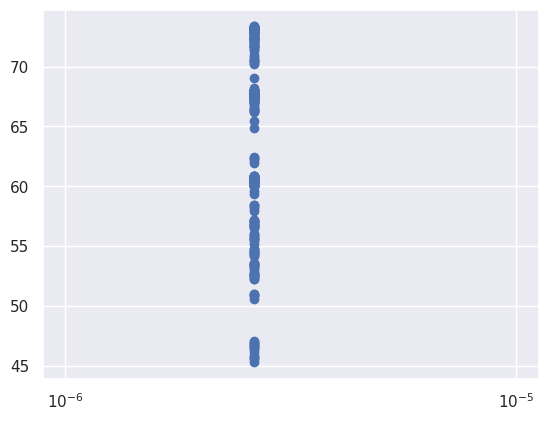

In [16]:
plt.scatter(area, gain)
plt.xscale("log")

In [17]:
len(diffpair_primitive_df)*len(activeload_primitive_df)*len(currentsource.parameters[Symbol("gcs")])

16800

In [18]:
currentsource.outputs[Symbol("W_cs")]

array([2.52452596e-05, 5.14425450e-05, 7.93852573e-05, 1.32548964e-04,
       2.43854417e-04, 3.49875637e-05, 2.68700092e-06, 7.76896592e-05,
       5.26922292e-06, 1.19261193e-04, 9.49094212e-06, 1.95119216e-04,
       1.81222102e-05, 3.55302986e-05, 5.40299456e-05, 3.18264099e-06,
       1.26394591e-04, 6.48600840e-06, 1.68036880e-06, 1.90836545e-04,
       1.16537025e-05, 3.14503618e-06, 2.21350651e-05, 6.20097587e-06,
       4.33024172e-05, 1.23581944e-05, 8.66186761e-05, 3.93963702e-06,
       2.12567333e-04, 8.26462165e-06, 1.88255754e-06, 1.47019969e-05,
       3.53857617e-06, 1.56282894e-06, 2.76561813e-05, 6.98319577e-06,
       3.09330016e-06, 5.38671571e-05, 1.39244411e-05, 6.18233421e-06,
       1.42340846e-04, 5.00718598e-06, 1.08661600e-06, 1.08332932e-05,
       2.13997015e-06, 1.90194203e-05, 4.02611298e-06, 1.69161043e-06,
       3.53389842e-05, 7.93824238e-06, 3.35680158e-06, 1.86188308e-06,
       6.84443373e-05, 1.58228654e-05, 6.71801463e-06, 3.71517860e-06])

In [19]:
OTA_macro.ext_mask = None

OTA_macro.primitives = [diffpair_primitive_wc, activeload_primmitive_wc, currentsource]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df_wc, ota_df_wc_mask = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OTA_macro
Netlist:  ota_1stage
Running MNA... 
MNA of gain_OTA took: 0.043207406997680664
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
MNA of rout_OTA took: 0.026055097579956055
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
MNA of gm_OTA took: 0.025663137435913086
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs*Rdiff_1*gaload

In [20]:
ota_df_wc["gain"] = 20*np.log10(ota_df_wc["gain_OTA"])
len(ota_df_wc)

1350

<Axes: xlabel='area', ylabel='gain'>

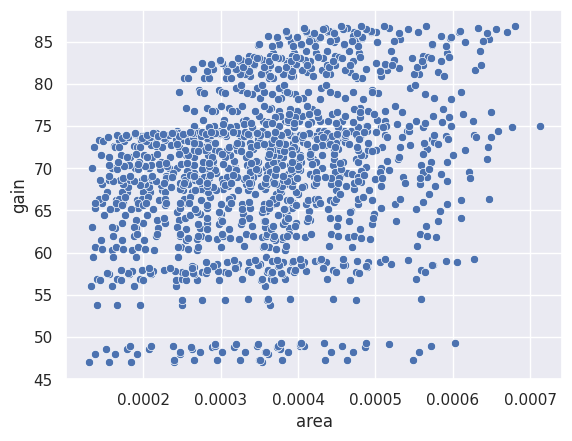

In [21]:
sns.scatterplot(data=ota_df_wc, x="area", y="gain")

In [22]:
OTA_macro.ext_mask = ota_df_wc_mask

OTA_macro.primitives = [diffpair_primitive, activeload_primmitive, currentsource]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df, _ = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  ota_1stage
Netlist:  ota_1stage
Running MNA... 
MNA of gain_OTA took: 0.03346443176269531
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
MNA of rout_OTA took: 0.029102563858032227
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
MNA of gm_OTA took: 0.0355837345123291
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs*Rdiff_1*gaload_1

In [23]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
len(ota_df)

1350

<Axes: xlabel='area', ylabel='gain'>

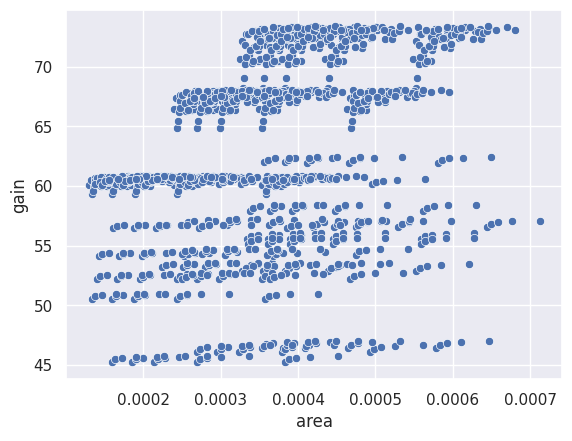

In [24]:
sns.scatterplot(data=ota_df, x="area", y="gain")

In [25]:
Cin_pt = 4.86e-12
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])

ota_df["bw"] = 1/(2*np.pi*ota_df["rout_OTA"]*Cin_pt)

mask = ota_df["gain"]>10
ota_df = ota_df[mask]

ota_df_new = ota_df
ota_df_new.sort_values(by="gain")

,Rdiff_1,gdiff_1,vbias,vs_diff,Raload_1,gaload_1,vbias_cm,gcs,Rcs,vs_cs,...,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,W_cs,L_cs,area,gain,gain_wc,bw
172,9.828165e+06,0.000112,1.188,0.1,1.966510e+06,0.000034,-0.906,0.000295,60789.088100,0.1,...,0.000004,4.000000e-07,0.000034,4.000000e-07,0.000244,6.400000e-06,0.000383,45.216479,60.350881,19957.472926
171,9.828165e+06,0.000112,1.188,0.1,1.966510e+06,0.000034,-0.906,0.000306,53190.042779,0.1,...,0.000004,4.000000e-07,0.000034,4.000000e-07,0.000133,3.200000e-06,0.000269,45.217061,60.350898,19957.738152
170,9.828165e+06,0.000112,1.188,0.1,1.966510e+06,0.000034,-0.906,0.000328,43886.524328,0.1,...,0.000004,4.000000e-07,0.000034,4.000000e-07,0.000079,1.600000e-06,0.000214,45.218022,60.350925,19958.176380
169,9.828165e+06,0.000112,1.188,0.1,1.966510e+06,0.000034,-0.906,0.000348,33476.298208,0.1,...,0.000004,4.000000e-07,0.000034,4.000000e-07,0.000051,8.000000e-07,0.000185,45.219655,60.350973,19958.921516
168,9.828165e+06,0.000112,1.188,0.1,1.966510e+06,0.000034,-0.906,0.000330,20459.025970,0.1,...,0.000004,4.000000e-07,0.000034,4.000000e-07,0.000025,4.000000e-07,0.000159,45.223616,60.351087,19960.729031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14396,4.188178e+07,0.000112,1.188,0.1,5.600978e+09,0.000054,-1.612,0.000295,60789.088100,0.1,...,0.000039,6.400000e-06,0.000054,6.400000e-06,0.000244,6.400000e-06,0.000646,73.362397,72.458693,787.598495
14395,4.188178e+07,0.000112,1.188,0.1,5.600978e+09,0.000054,-1.612,0.000306,53190.042779,0.1,...,0.000039,6.400000e-06,0.000054,6.400000e-06,0.000133,3.200000e-06,0.000532,73.362397,72.458698,787.600062
14394,4.188178e+07,0.000112,1.188,0.1,5.600978e+09,0.000054,-1.612,0.000328,43886.524328,0.1,...,0.000039,6.400000e-06,0.000054,6.400000e-06,0.000079,1.600000e-06,0.000477,73.362397,72.458705,787.602649
14393,4.188178e+07,0.000112,1.188,0.1,5.600978e+09,0.000054,-1.612,0.000348,33476.298208,0.1,...,0.000039,6.400000e-06,0.000054,6.400000e-06,0.000051,8.000000e-07,0.000448,73.362398,72.458717,787.607050


In [26]:
ota_df_wc_new = ota_df_wc[mask]
ota_df_wc_new

,Rdiff_1,gdiff_1,vbias,vs_diff,Raload_1,gaload_1,vbias_cm,gcs,Rcs,vs_cs,...,W_diff_m2,L_diff_m2,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,W_cs,L_cs,area,gain
0,4.682790e+07,0.000112,1.188,0.1,3.626473e+07,0.000202,-1.373,0.000330,20459.025970,0.1,...,4.000000e-07,4.000000e-07,0.000002,4.000000e-07,0.000030,4.000000e-07,0.000025,4.000000e-07,0.000153,67.194663
1,4.682790e+07,0.000112,1.188,0.1,3.626473e+07,0.000202,-1.373,0.000348,33476.298208,0.1,...,4.000000e-07,4.000000e-07,0.000002,4.000000e-07,0.000030,4.000000e-07,0.000051,8.000000e-07,0.000179,67.194626
2,4.682790e+07,0.000112,1.188,0.1,3.626473e+07,0.000202,-1.373,0.000328,43886.524328,0.1,...,4.000000e-07,4.000000e-07,0.000002,4.000000e-07,0.000030,4.000000e-07,0.000079,1.600000e-06,0.000208,67.194611
3,4.682790e+07,0.000112,1.188,0.1,3.626473e+07,0.000202,-1.373,0.000306,53190.042779,0.1,...,4.000000e-07,4.000000e-07,0.000002,4.000000e-07,0.000030,4.000000e-07,0.000133,3.200000e-06,0.000263,67.194602
4,4.682790e+07,0.000112,1.188,0.1,3.626473e+07,0.000202,-1.373,0.000295,60789.088100,0.1,...,4.000000e-07,4.000000e-07,0.000002,4.000000e-07,0.000030,4.000000e-07,0.000244,6.400000e-06,0.000377,67.194597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15064,2.101550e+08,0.000112,1.188,0.1,8.555935e+06,0.000198,-1.612,0.000330,20459.025970,0.1,...,4.000000e-07,1.600000e-06,0.000066,6.400000e-06,0.000009,6.400000e-06,0.000025,4.000000e-07,0.000403,59.283242
15065,2.101550e+08,0.000112,1.188,0.1,8.555935e+06,0.000198,-1.612,0.000348,33476.298208,0.1,...,4.000000e-07,1.600000e-06,0.000066,6.400000e-06,0.000009,6.400000e-06,0.000051,8.000000e-07,0.000429,59.283084
15066,2.101550e+08,0.000112,1.188,0.1,8.555935e+06,0.000198,-1.612,0.000328,43886.524328,0.1,...,4.000000e-07,1.600000e-06,0.000066,6.400000e-06,0.000009,6.400000e-06,0.000079,1.600000e-06,0.000458,59.283019
15067,2.101550e+08,0.000112,1.188,0.1,8.555935e+06,0.000198,-1.612,0.000306,53190.042779,0.1,...,4.000000e-07,1.600000e-06,0.000066,6.400000e-06,0.000009,6.400000e-06,0.000133,3.200000e-06,0.000513,59.282981


/tmp/ipykernel_2613/4192085568.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc = 'upper right')
/tmp/ipykernel_2613/4192085568.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc = 'upper right')
/tmp/ipykernel_2613/4192085568.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc = 'upper right')


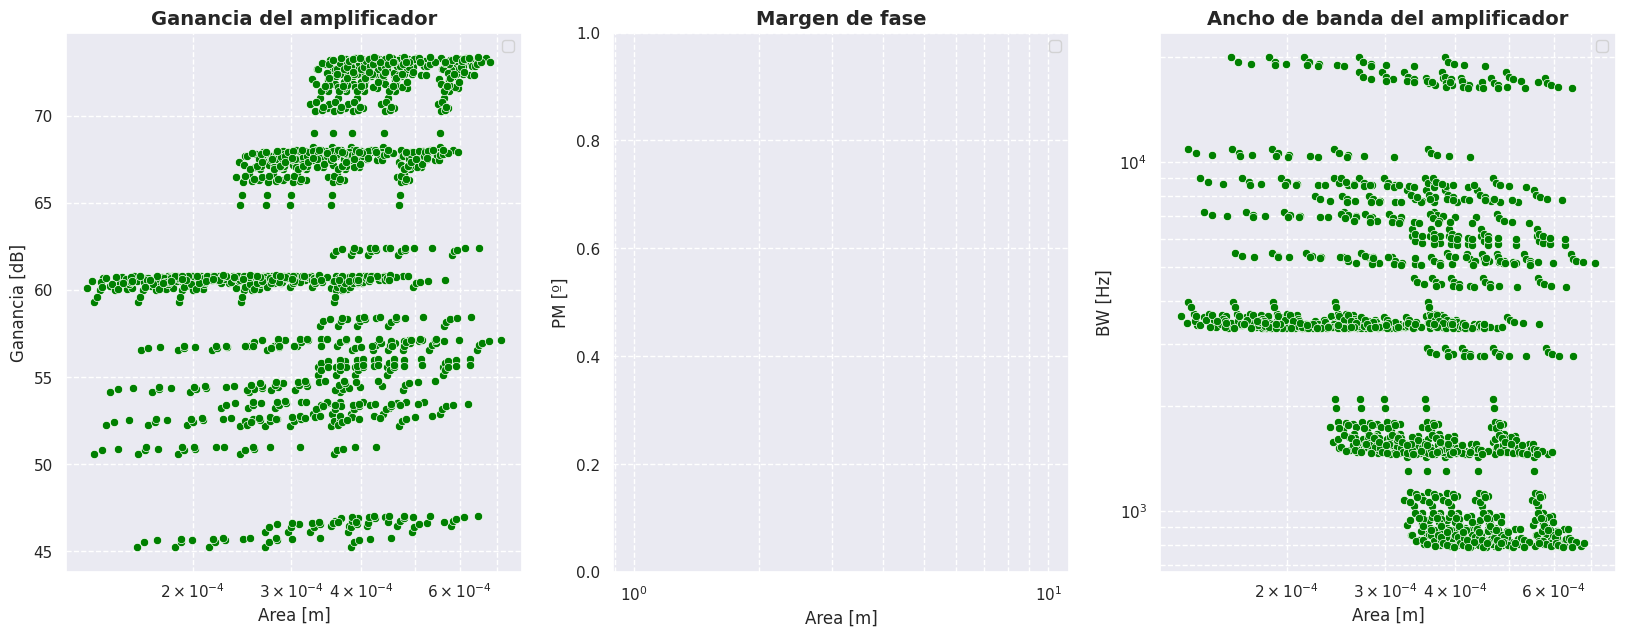

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
#sns.scatterplot(ax=axs[0], data=ota_df, x='area', y='gain', palette='flare')
sns.scatterplot(ax=axs[0], data=ota_df_new, x='area', y='gain', color="green")
#sns.scatterplot(ax=axs[1], data=ota_df, x="area", y="phase_margin_OTA", hue="phase_margin_OTA_wc", palette='flare')
#sns.scatterplot(ax=axs[1], data=ota_df_new, x="area", y="phase_margin_OTA", color="green")
#sns.scatterplot(ax=axs[2], data=ota_df, x="area", y="bw", hue_norm=LogNorm(), palette='flare')
sns.scatterplot(ax=axs[2], data=ota_df_new, x="area", y="bw", color="green")

axs[0].set_title(r"Ganancia del amplificador", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Area [m]")
axs[1].set_ylabel(r"PM [º]")
axs[1].legend(loc = 'upper right')

axs[2].set_xlabel(r"Area [m]")
axs[2].set_ylabel(r"BW [Hz]")
axs[2].set_title(r"Ancho de banda del amplificador", fontsize=14, weight='bold')
axs[2].legend(loc = 'upper right')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  
axs[2].grid(True,which="both",ls="--")  

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

axs[2].set_yscale('log')

#sns.move_legend(axs[0], "upper left",title="ganancia segunda etapa")

plt.savefig('fullcc_ota_explore_raw_SKY.pdf')

In [33]:
OTA_primitive_wc = Primitive(
    parameters={
        Symbol("Ra"): ota_df_wc_new["rout_OTA"],
        Symbol("gma"): ota_df_wc_new["gm_OTA"],
    }
)

OTA_primitive_wc.outputs = {
    Symbol("W_diff_m1"): ota_df_wc_new[Symbol("W_diff_m1")].values,
    Symbol("L_diff_m1"): ota_df_wc_new[Symbol("L_diff_m1")].values,
    Symbol("W_diff_m2"): ota_df_wc_new[Symbol("W_diff_m2")].values,
    Symbol("L_diff_m2"): ota_df_wc_new[Symbol("L_diff_m2")].values,

    Symbol("W_aload_m1"): ota_df_wc_new[Symbol("W_aload_m1")].values,
    Symbol("L_aload_m1"): ota_df_wc_new[Symbol("L_aload_m1")].values,
    Symbol("W_aload_m2"): ota_df_wc_new[Symbol("W_aload_m2")].values,
    Symbol("L_aload_m2"): ota_df_wc_new[Symbol("L_aload_m2")].values,

    Symbol("W_cs"): ota_df_wc_new[Symbol("W_cs")].values,
    Symbol("L_cs"): ota_df_wc_new[Symbol("L_cs")].values,
}

In [34]:
pt_2_wc = Primitive(
    parameters={
        Symbol('gm_pt'): np.asarray([0.001543295686831]),
        Symbol('Ro_pt'): np.asarray([90994.8023538388]),
        Symbol("Cgg_pt"): np.asarray([1.0210799490783093e-12]),
        Symbol("Cgd_pt"): np.asarray([1.0190197779098047e-15]),
        Symbol("Cin_pt"): np.asarray([1.1641828183581444e-12]),
        Symbol("dropout"): np.asarray([0.0971945954880531]),
        Symbol('Vota'): np.asarray([1.057873324243474])
    }
)

pt_2_wc.outputs = {
    Symbol("W_pt"): np.asarray([0.0009077961345068]),
    Symbol("L_pt"): np.asarray([4e-7])
}

In [35]:
Cc_primitive_LDO_2 = Primitive(
    parameters={
        Symbol("Cc"): np.asarray([3.1622776601683798e-12, 1e-12, 3.1622e-12, 1e-12]),
        Symbol("Rc"): np.asarray([1000.0, 1000, 3162, 3162])
    }
)

Cc_primitive_LDO_2.outputs = {
    Symbol("W_cc"): np.sqrt(Cc_primitive_LDO_2.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("L_cc"): np.sqrt(Cc_primitive_LDO_2.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("W_rc"): np.sqrt(Cc_primitive_LDO_2.parameters[Symbol("Rc")]/(1360*0.5))*1e-6,
    Symbol("L_rc"): np.repeat(0.5e-6, 4)
}

In [36]:
LDO_macro.ext_mask = None

LDO_macro.primitives = [OTA_primitive_wc, pt_2_wc, Cc_primitive_LDO_2]
LDO_macro.submacromodels = []
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df_wc, ldo_df_wc_mask = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  LDO_macro
Netlist:  ldo
Running MNA... 
MNA of psrr_LDO took: 0.05698442459106445
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
MNA of dc_LDO took: 0.028174161911010742
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
MNA of gain_ol_LDO took: 0.0364222526550293
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol
Running MNA... 
MNA of phase_margin_LDO took: 0.022117137908935547
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(3840000.0*Ro_pt*gm_pt + 3840000.0)/(2880000.0*Ra*Ro_pt*gm_pt*gma + 16240.0*Ro_pt + 3840000.0)
lambdify variables: (Ra, gma, gm_pt, Ro_pt, Cgg_pt, Cgd_pt, Cin_pt, dropout, Vota, Cc, Rc) <fun

In [37]:
OTA_primitive = Primitive(
    parameters={
        Symbol("Ra"): ota_df_new["rout_OTA"],
        Symbol("gma"): ota_df_new["gm_OTA"],
    }
)

OTA_primitive.outputs = {
    Symbol("W_diff_m1"): ota_df_new[Symbol("W_diff_m1")].values,
    Symbol("L_diff_m1"): ota_df_new[Symbol("L_diff_m1")].values,
    Symbol("W_diff_m2"): ota_df_new[Symbol("W_diff_m2")].values,
    Symbol("L_diff_m2"): ota_df_new[Symbol("L_diff_m2")].values,

    Symbol("W_aload_m1"): ota_df_new[Symbol("W_aload_m1")].values,
    Symbol("L_aload_m1"): ota_df_new[Symbol("L_aload_m1")].values,
    Symbol("W_aload_m2"): ota_df_new[Symbol("W_aload_m2")].values,
    Symbol("L_aload_m2"): ota_df_new[Symbol("L_aload_m2")].values,

    Symbol("W_cs"): ota_df_new[Symbol("W_cs")].values,
    Symbol("L_cs"): ota_df_new[Symbol("L_cs")].values,
}

In [38]:
pt_2 = Primitive(
    parameters={
        Symbol('gm_pt'): np.asarray([0.0266634512908571]),
        Symbol('Ro_pt'): np.asarray([1767.5635905016463]),
        Symbol("Cgg_pt"): np.asarray([1.2022408576105078e-12]),
        Symbol("Cgd_pt"): np.asarray([2.2391190852909668e-15]),
        Symbol("Cin_pt"): np.asarray([1.3077690750420409e-12]),
        Symbol("dropout"): np.asarray([0.3806709000001225]),
        Symbol('Vota'): np.asarray([0.6888888888888889])
    }
)

pt_2.outputs = {
    Symbol("W_pt"): np.asarray([0.0009077961345068]),
    Symbol("L_pt"): np.asarray([4e-7])
}

In [39]:
LDO_macro.ext_mask = ldo_df_wc_mask

LDO_macro.primitives = [OTA_primitive, pt_2, Cc_primitive_LDO_2]
LDO_macro.submacromodels = []
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df, _ = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo_ol
Netlist:  ldo
Running MNA... 
MNA of psrr_LDO took: 0.04080796241760254
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
MNA of dc_LDO took: 0.024490833282470703
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
MNA of gain_ol_LDO took: 0.024593830108642578
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol
Running MNA... 
MNA of phase_margin_LDO took: 0.020909547805786133
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(3840000.0*Ro_pt*gm_pt + 3840000.0)/(2880000.0*Ra*Ro_pt*gm_pt*gma + 16240.0*Ro_pt + 3840000.0)
lambdify variables: (Ra, gma, gm_pt, Ro_pt, Cgg_pt, Cgd_pt, Cin_pt, dropout, Vota, Cc, Rc) <func

In [51]:
ldo_df["psrr"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df["psrr_wc"] = 20*np.log10(ldo_df_wc["psrr_LDO"])

ldo_df['gain_ol'] = 20*np.log10(ldo_df['gain_ol_LDO'])
ldo_df['gain_ol_wc'] = 20*np.log10(ldo_df_wc['gain_ol_LDO'])

ldo_df["Vota_wc"] = ldo_df_wc[Symbol("Vota")]
ldo_df["cin_pt_wc"] = ldo_df_wc[Symbol("Cin_pt")]

ldo_df['gmid'] = ldo_df[Symbol('gm_pt')]/pt.inputs['il']

ldo_df["phase_margin_LDO_wc"] = ldo_df_wc["phase_margin_LDO"]

ldo_df['loadreg'] = np.abs(ldo_df['dc_LDO']-ldo_df_wc['dc_LDO'])/IL

ldo_df["bw"] = 1/(2*np.pi*ldo_df[Symbol("Ra")]*(ldo_df[Symbol("Cin_pt")]+ldo_df[Symbol("gm_pt")]*ldo_df[Symbol("Ro_pt")]*ldo_df[Symbol("Cc")]))    
ldo_df["gain_ota"] = 20*np.log10(ldo_df[Symbol("Ra")]*ldo_df[Symbol("gma")])

#ldo_df = ldo_df[(ldo_df["gain_ota"]>20) & (ldo_df[Symbol("W_pt")]<0.6e-3) & (ldo_df[Symbol("dropout")]<0.4)]

ldo_df_new = ldo_df[((ldo_df[Symbol("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df[Symbol("W_pt")]<1e-3)  & (ldo_df["bw"]>100)  & (ldo_df["loadreg"]<1))]
#ldo_df_new = ldo_df
ldo_df_new.sort_values(by="area")

,Ra,gma,gm_pt,Ro_pt,Cgg_pt,Cgd_pt,Cin_pt,dropout,Vota,Cc,...,psrr_wc,gain_ol,gain_ol_wc,Vota_wc,cin_pt_wc,gmid,phase_margin_LDO_wc,loadreg,bw,gain_ota
741,1.565679e+07,0.000112,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-71.898745,79.778842,65.674473,1.057873,1.164183e-12,5.253882,89.758415,0.589696,209.864595,64.876137
743,1.565679e+07,0.000112,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-71.898745,79.778842,65.674473,1.057873,1.164183e-12,5.253882,90.968731,0.589696,209.864595,64.876137
981,1.822821e+07,0.000112,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-76.497399,81.100601,70.275604,1.057873,1.164183e-12,5.253882,89.746159,0.469398,180.259332,66.197896
983,1.822821e+07,0.000112,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-76.497399,81.100601,70.275604,1.057873,1.164183e-12,5.253882,90.956466,0.469398,180.259332,66.197896
3081,1.894546e+07,0.000112,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-65.732507,81.435961,59.502004,1.057873,1.164183e-12,5.253882,89.789268,0.653094,173.434941,66.533256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2.968618e+07,0.000112,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-68.241811,85.337820,62.014384,1.057873,1.164183e-12,5.253882,90.984359,0.447757,110.684684,70.435115
1597,2.243995e+07,0.000112,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-80.157739,82.906426,73.937164,1.057873,1.164183e-12,5.253882,89.740123,0.368663,146.426607,68.003721
1599,2.243995e+07,0.000112,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-80.157739,82.906426,73.937164,1.057873,1.164183e-12,5.253882,90.950426,0.368663,146.426607,68.003721
5197,2.213983e+07,0.000112,0.026663,1767.563591,1.202241e-12,2.239119e-15,1.307769e-12,0.380671,0.688889,1.000000e-12,...,-80.631499,82.789377,74.411047,1.057873,1.164183e-12,5.253882,89.739512,0.370128,148.411543,67.886672


In [52]:
pareto_dict = {"area": ldo_df_new["area"].values, "pm": ldo_df_new["phase_margin_LDO_wc"].values}
pareto_df = pd.DataFrame(pareto_dict)

mask = pareto.paretoset(pareto_df, sense=["min", "max"])

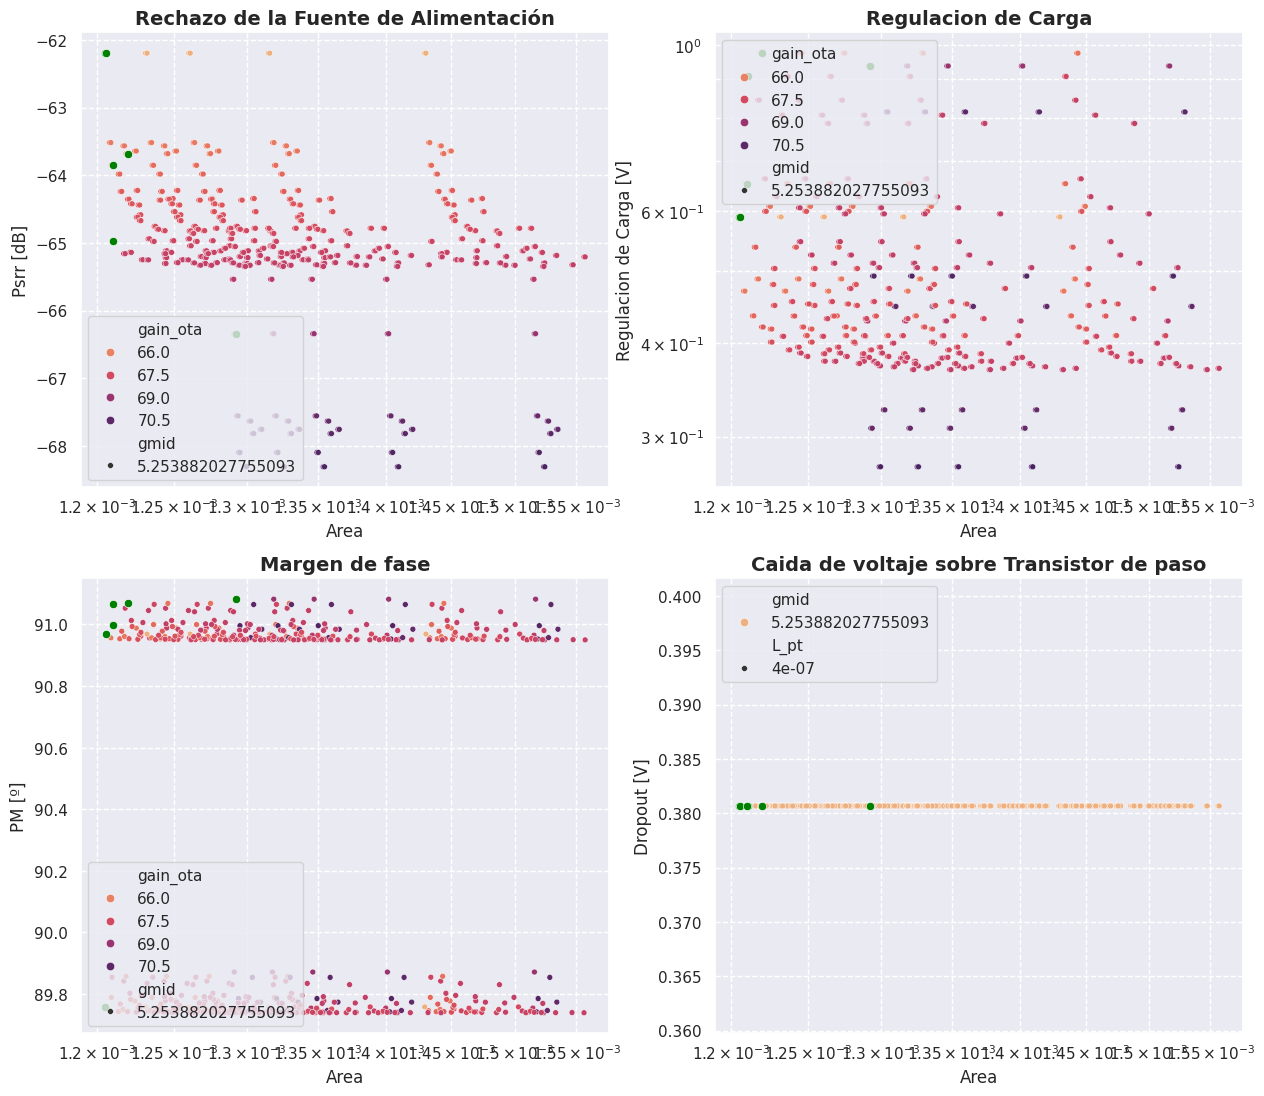

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
sns.scatterplot(ax=axs[0,0], data=ldo_df_new, x='area', y='psrr', palette='flare', hue='gain_ota', rasterized=True, size='gmid')
sns.scatterplot(ax=axs[0,0], data=ldo_df_new[mask], x='area', y='psrr', c='green')
sns.scatterplot(ax=axs[0,1], data=ldo_df_new, x='area', y='loadreg', palette='flare', rasterized=True, hue='gain_ota', size='gmid')
sns.scatterplot(ax=axs[0,1], data=ldo_df_new[mask], x='area', y='loadreg', c='green')
sns.scatterplot(ax=axs[1,1], data=ldo_df_new, x='area', y=Symbol('dropout'), palette='flare', hue='gmid', rasterized=True, size=Symbol('L_pt'))
sns.scatterplot(ax=axs[1,1], data=ldo_df_new[mask], x='area', y=Symbol('dropout'), c='green')
sns.scatterplot(ax=axs[1,0], data=ldo_df_new, x='area', y="phase_margin_LDO_wc", palette='flare', hue="gain_ota", rasterized=True, size='gmid')
sns.scatterplot(ax=axs[1,0], data=ldo_df_new[mask], x='area', y="phase_margin_LDO_wc", c='green')

axs[0,0].set_title(r"Rechazo de la Fuente de Alimentación", fontsize=14, weight='bold')
axs[0,0].set_xlabel(r"Area")
axs[0,0].set_ylabel(r"Psrr [dB]")
axs[0,0].locator_params(axis='x', nbins=10) 
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title(r"Regulacion de Carga", fontsize=14, weight='bold')
axs[0,1].set_xlabel(r"Area")
axs[0,1].set_ylabel(r"Regulacion de Carga [V]")
axs[0,1].legend(loc = 'upper right')

axs[1,1].set_xlabel(r"Area")
axs[1,1].set_ylabel(r"Dropout [V]")
axs[1,1].set_title(r"Caida de voltaje sobre Transistor de paso", fontsize=14, weight='bold')
axs[1,1].legend(loc = 'upper right')

axs[1,0].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1,0].set_xlabel(r"Area")
axs[1,0].set_ylabel(r"PM [º]")
axs[1,0].legend(loc = 'upper right')
#fig.suptitle(r"Ganancias intrínsecas", fontsize=24, y=1.1)

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')

axs[0,1].set_yscale('log')



axs[0,0].grid(True,which="both",ls="--")  
axs[0,1].grid(True,which="both",ls="--")  
axs[1,0].grid(True,which="both",ls="--")  
axs[1,1].grid(True,which="both",ls="--")  

sns.move_legend(axs[0,0], "lower left")
sns.move_legend(axs[0,1], "upper left")
sns.move_legend(axs[1,0], "lower left")
sns.move_legend(axs[1,1], "upper left")

plt.savefig('ldo_explore_raw.pdf')

In [54]:
ldo_df_new[mask].to_csv("data/GF_lv_ldo_final_98_10_10_telescopica.csv")